In [4]:
from missing_bids import auction_data, analytics, environments
hist_plot = auction_data.hist_plot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

sns.set_style('white')
%matplotlib inline

In [6]:
# getting data directory

path_data = None #path/to/data (if you know it, otherwise, we'll find it below)

if path_data is None:
    name = 'data_for_missing_bids_figures'
    for root, dirs, _ in os.walk('/'):
        if name in dirs:
            path_data = os.path.join(root, name)
            break
        
print('data located at \n\t{}'.format(path_data))
path_figures = os.path.join(path_data, 'figures')

if not os.path.exists(path_figures):
    os.makedirs(path_figures)

data located at 
	/home/sylvain/Dropbox/Econ/papiers/gameTheory/missing_bids/data/data_for_missing_bids_figures


In [7]:
# set global optimization parameters

num_points = 3000
number_iterations = 5
confidence_level = .95
list_ks = [0.5, 1, 1.5, 2]

In [11]:
def compute_minimization_solution(data, deviations, max_markup=.5):
    demands = [data.get_counterfactual_demand(rho) for rho in deviations]
    solutions = []
    filter_ties = auction_data.FilterTies(tolerance=.0001)
    filtered_data = filter_ties(data)
    share_ties = filter_ties.get_ties(data).mean()

    for k in list_ks:
        constraints = [environments.MarkupConstraint(max_markup=max_markup, min_markup=.02), 
                   environments.InformationConstraint(k=k, sample_demands=demands)]

        min_collusion_solver = analytics.MinCollusionIterativeSolver(
            data=filtered_data, 
            deviations=deviations, 
            metric=analytics.IsNonCompetitive, 
            plausibility_constraints=constraints, 
            num_points=num_points, 
            seed=0, 
            project=False, 
            filter_ties=None,
            number_iterations=number_iterations,
            confidence_level=confidence_level,
            moment_matrix=auction_data.moment_matrix(deviations, 'slope'),
            moment_weights=np.array([0, 0, 1])
        )

        share_collusive = min_collusion_solver.result.solution    
        solutions.append(1 - share_collusive)
        del min_collusion_solver
    del filtered_data
    return np.array(solutions), share_ties

In [14]:
def pretty_plot(title, list_solutions, labels, mark=['k.:', 'k.-']):
    plt.title(title)
    for i, (solutions, label) in enumerate(zip(list_solutions, labels)):
        plt.plot(list_ks, solutions, mark[i], label=label)
    plt.legend(loc='lower right')
    plt.axis([list_ks[0], list_ks[-1], 0, 1.05])
    plt.xlabel('k')
    plt.ylabel('share of competitive histories')
    plt.savefig(os.path.join(path_figures, '{}.pdf'.format(title)))
    plt.show()

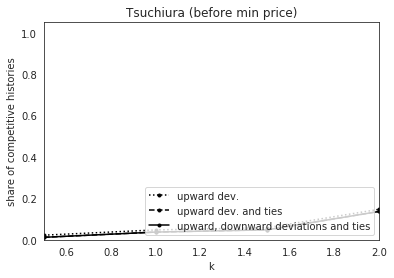

In [15]:
# illustrating impact of different IC constraints, city data

tsuchiura_data = auction_data.AuctionData(os.path.join(path_data, 'tsuchiura_data.csv'))

tsuchiura_before_min_price = auction_data.AuctionData(
    tsuchiura_data.df_bids.loc[tsuchiura_data.data.minprice.isnull()])
 
all_deviations = [-.02, .0, .0008]
up_deviations = [.0, .0008]

solutions_all_deviations, share_ties = compute_minimization_solution(
    tsuchiura_before_min_price, all_deviations, .25)
solutions_up_deviations, share_ties = compute_minimization_solution(
    tsuchiura_before_min_price, all_deviations, .25)

solutions_all_deviations_w_ties = solutions_all_deviations * (1 - share_ties)
solutions_up_deviations_w_ties = solutions_up_deviations * (1 - share_ties)
solutions_up_deviations_wo_ties = solutions_up_deviations + share_ties * (1- solutions_up_deviations)

pretty_plot(
    'Tsuchiura (before min price)', 
    [solutions_up_deviations_wo_ties, 
     solutions_up_deviations_w_ties, 
     solutions_all_deviations_w_ties],
    ['upward dev.', 'upward dev. and ties', 'upward, downward deviations and ties'],
    ['k.:', 'k.--', 'k.-']
)
    

Bridges
collecting and processing data
computing before/after problem solution
plotting results


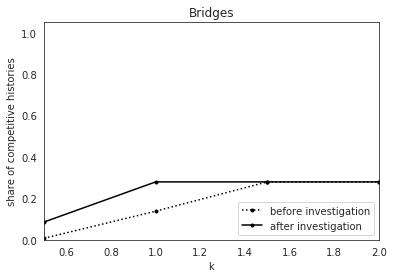

Electric
collecting and processing data
computing before/after problem solution
plotting results


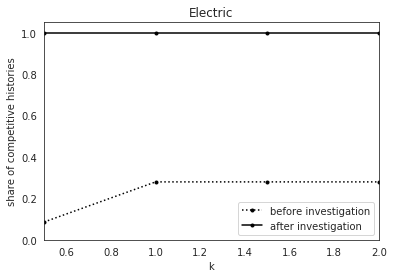

Pre-Stressed Concrete
collecting and processing data
computing before/after problem solution
plotting results


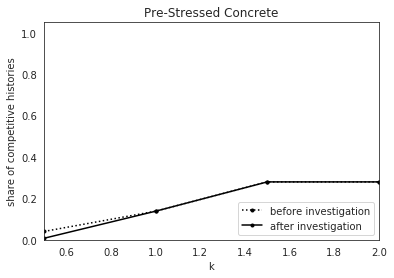

Floods
collecting and processing data
computing before/after problem solution
plotting results


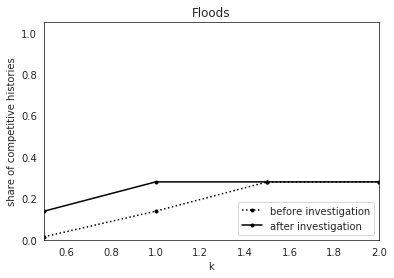

In [10]:
# before/after industry comparisons

list_data_sets = [('Bridges', 'bc_collusion.csv', [-.025, .0, .001]),
                  ('Electric', 'ec_collusion.csv', [-.025, .0, .001]),
                  ('Pre-Stressed Concrete', 'pc_collusion.csv', [-.025, .0, .001]),
                  ('Floods', 'fc_collusion.csv', [-.03, .0, .001])]

for industry, file, deviations in list_data_sets:
    print('='*20 + '\n' + industry)
    print('collecting and processing data')
    data = auction_data.AuctionData(os.path.join(path_data, file))
    data_before = auction_data.AuctionData(data.df_bids.loc[data.data.before==1])
    data_after = auction_data.AuctionData(data.df_bids.loc[data.data.before.isnull()])
    
    print('computing before/after problem solution')
    solutions_before, _ = compute_minimization_solution(data_before, deviations)
    solutions_after, _ = compute_minimization_solution(data_after, deviations)
    del data
    del data_before
    del data_after
    
    print('plotting results')
    pretty_plot(
        industry, 
        [solutions_before, solutions_after], 
        ["before investigation", "after investigation"]
    )

0.1900002835287281
0.5257744274357027
0.999999999811592
0.9999999996857518
1.0000000000001124
1.0000000000035654
1.0000000000019122
1.0000000000002283


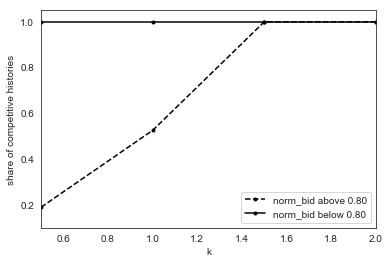

In [27]:
national_data = auction_data.AuctionData('../tests/reference_data/sample_with_firm_rank.csv')

filter_ties = auction_data.FilterTies(tolerance=.0001)
filtered_data = filter_ties(national_data)



filtered_data_above = auction_data.AuctionData.from_clean_bids(
    filtered_data.df_bids.loc[filtered_data.data.norm_bid>0.8])

filtered_data_below = auction_data.AuctionData.from_clean_bids(
    filtered_data.df_bids.loc[filtered_data.data.norm_bid<0.8])


k_array = [0.5, 1, 1.5, 2]
comp_histories_below = []
comp_histories_above = []


deviations = [-.025, .0, .001]
demands_below = [filtered_data_below.get_counterfactual_demand(rho) for rho in deviations]
demands_above = [filtered_data_above.get_counterfactual_demand(rho) for rho in deviations]


#share_ties_below = filter_ties.get_ties(national_data_below_80).mean()

#share_ties_above = filter_ties.get_ties(national_data_above_80).mean()

for k_0 in k_array:
    constraints = [environments.MarkupConstraint(max_markup=.5, min_markup=.02), 
               environments.InformationConstraint(k=k_0, sample_demands=demands_above)]
    
    
    min_collusion_solver = analytics.MinCollusionIterativeSolver(
        data=filtered_data_above, 
        deviations=deviations, 
        metric=analytics.IsNonCompetitive, 
        plausibility_constraints=constraints, 
        num_points=30000.0, 
        seed=0, 
        project=False, 
        filter_ties=None,
        number_iterations=350,
        confidence_level=.95,
        moment_matrix=auction_data.moment_matrix(deviations, 'slope'),
        moment_weights=np.array([0, 0, 1])
    )

    share = min_collusion_solver.result.solution
    print(1 - share)            
    comp_histories_above.append(1 - share)
    

for k_0 in k_array:
    constraints = [environments.MarkupConstraint(max_markup=.5, min_markup=.02), 
               environments.InformationConstraint(k=k_0, sample_demands=demands_below)]
        
    min_collusion_solver = analytics.MinCollusionIterativeSolver(
        data=filtered_data_below, 
        deviations=deviations, 
        metric=analytics.IsNonCompetitive, 
        plausibility_constraints=constraints, 
        num_points=30000.0, 
        seed=0, 
        project=False, 
        filter_ties=None,
        number_iterations=350,
        confidence_level=.95,
        moment_matrix=auction_data.moment_matrix(deviations, 'slope'),
        moment_weights=np.array([0, 0, 1])
    )

    share = min_collusion_solver.result.solution
    print(1 - share)            
#    result = min_collusion_solver.result
#    result_up = min_collusion_solver_up.result
    comp_histories_below.append(1 - share)


plt.plot(k_array,comp_histories_above, 'k.--', label="norm_bid above 0.80")
plt.plot(k_array,comp_histories_below, 'k.-', label="norm_bid below 0.80")
plt.legend(loc='lower right')
plt.axis([0.5, 2, 0.1, 1.05])
plt.xlabel('k')
plt.ylabel('share of competitive histories')  
plt.savefig('above_below_80.pdf')


In [ ]:
national_data = auction_data.AuctionData('../tests/reference_data/sample_with_firm_rank.csv')
filter_ties = auction_data.FilterTies(tolerance=.0001)
filtered_data = filter_ties(national_data)

comp_histories_firms_2 = []

#firms = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
deviations = [-.025, .0, .001]
count = 1

while count < 11:
    filtered_data_firm = auction_data.AuctionData.from_clean_bids(
    filtered_data.df_bids.loc[filtered_data.data.rank2 == count])
    demand_firm = [filtered_data_firm.get_counterfactual_demand(rho) for rho in deviations]
    print(demand_firm)
    constraints = [environments.MarkupConstraint(max_markup=.5, min_markup=.02), 
    environments.InformationConstraint(k=1, sample_demands=demand_firm)]

    min_collusion_solver = analytics.MinCollusionIterativeSolver(
        data=filtered_data_firm, 
        deviations=deviations, 
        metric=analytics.IsNonCompetitive, 
        plausibility_constraints=constraints, 
        num_points=30000.0, 
        seed=0, 
        project=False, 
        filter_ties=None,
        number_iterations=500,
        confidence_level=.95,
        moment_matrix=auction_data.moment_matrix(deviations, 'slope'),
        moment_weights=np.array([0, 0, 1])
    )

    share = min_collusion_solver.result.solution
    print(1 - share) 
    comp_histories_firms_2.append(1 - share)
    count = count + 1
    
print(comp_histories_firms_2)

[0.2633498306850742, 0.17712946079708258, 0.17712946079708258]
0.5983225146928144
[0.15198956294846705, 0.1004566210045662, 0.1004566210045662]


In [31]:
print(comp_histories_firms_2)

[0.5983225785780911, 0.6802485938054595, 0.5983227188764317, 0.999999999996455, 0.6802486191487804, 0.12868268014296702, 0.1540303084010337, 0.1484759388140957, 0.6802488600281172, 0.15403031065044115, 0.5983224688964097, 0.6802491370470429, 0.14847594652930796, 0.1484759388998611, 0.9457864553052578, 0.1540303097504846, 0.6802487829774598, 0.14847594204754122, 0.1484759389661695, 1.0000000000062657, 0.16394525190076736, 1.000000000007576, 0.16394525271129934, 1.000000000000639, 0.1639452517060359, 0.9627616318719026, 0.16394526207861293, 0.5983224878333374, 0.16394525409827598, 0.598322458065558]


In [29]:
## Deviation temptation relative to profits -- Tsuchiura

[0.657617728531856, 0.21772853185595567, 0.21772853185595567]
0.024902024123935135
0.022800669295295613
0.0024582288933275498
0.0014624909312142519
[0.024902024123935135, 0.022800669295295613, 0.0024582288933275498, 0.0014624909312142519]


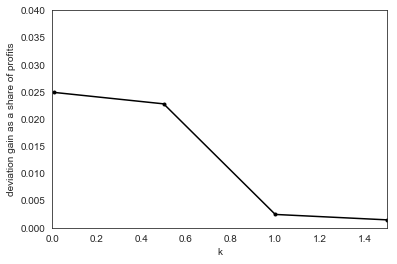

In [30]:
tsuchiura_data = auction_data.AuctionData('../tests/reference_data/tsuchiura_data.csv')
tsuchiura_before_min_price = auction_data.AuctionData(
    tsuchiura_data.df_bids.loc[tsuchiura_data.data.minprice.isnull()])


k_array = [0.01, 0.5, 1, 1.5]
dev_gain = []

deviations = [-.02, .0, .0008]

filter_ties = auction_data.FilterTies(tolerance=.0001)
filtered_data = filter_ties(tsuchiura_before_min_price)
demands = [filtered_data.get_counterfactual_demand(rho) for rho in deviations]
print(demands)
share_ties = filter_ties.get_ties(filtered_data).mean()


for k_0, p in zip(k_array, [True, False, False, False]):
    constraints = [environments.MarkupConstraint(max_markup=.5, min_markup=.02), 
               environments.InformationConstraint(k=k_0, sample_demands=demands)]
    
    min_collusion_solver = analytics.MinCollusionIterativeSolver(
        data=filtered_data, 
        deviations=deviations, 
        metric=analytics.DeviationTemptationOverProfits, 
        plausibility_constraints=constraints, 
        num_points=10000+(1 - p)*20000, 
        seed=0, 
        project=p, 
        number_iterations=350,
        confidence_level=.95,
        filter_ties=None,
        moment_matrix=auction_data.moment_matrix(deviations, 'slope'),
        moment_weights=np.array([0, 0, 1])
    )

    gain = min_collusion_solver.result.solution
    print(gain)            
    dev_gain.append(gain)

print(dev_gain)


plt.plot(k_array,dev_gain, 'k.-')
plt.axis([0, 1.5, 0, 0.04])
plt.xlabel('k')
plt.ylabel('deviation gain as a share of profits')  
plt.savefig('tsuchiura_before_dev_gain.pdf')